### Dataset pochodzi z [Kaggle](https://www.kaggle.com/zynicide/wine-reviews/data#winemag-data-130k-v2.csv), gdzie znajduje się opis zawartości poszczególnych kolumn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.sparse import hstack
from sklearn.linear_model import LassoCV
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
sns.set()

In [2]:
df = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
df = df[['country', 'points', 'price', 'province', 'taster_name', 'variety', 'winery', 'description']]

In [4]:
df = df.dropna()

In [5]:
df.describe()

,points,price
count,96420.000000,96420.000000
mean,88.585625,35.005009
std,2.951817,43.069060
min,80.000000,4.000000
25%,87.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,40.000000
max,100.000000,3300.000000


Po odrzuceniu recencji, które nie mają podanych wszystkich interesujących Nas kolumn dostajemy blisko 100 000 recenzji win z oceną od 80 do 100 punktów.

In [6]:
df['description_length'] = df['description'].str.len()
df['log_price'] = np.log(df['price'])

W analizie przydadzą się powyższe kolumny - długość tekstu, który informuje ile wysiłku zostało włożone w napisanie recenzji oraz transformacja logarytmiczna wartości z *price*, która również okaże się pomocna.

In [7]:
df

,country,points,price,province,taster_name,variety,winery,description,description_length,log_price
1,Portugal,87,15.0,Douro,Roger Voss,Portuguese Red,Quinta dos Avidagos,"This is ripe and fruity, a wine that is smooth...",227,2.708050
2,US,87,14.0,Oregon,Paul Gregutt,Pinot Gris,Rainstorm,"Tart and snappy, the flavors of lime flesh and...",186,2.639057
3,US,87,13.0,Michigan,Alexander Peartree,Riesling,St. Julian,"Pineapple rind, lemon pith and orange blossom ...",199,2.564949
4,US,87,65.0,Oregon,Paul Gregutt,Pinot Noir,Sweet Cheeks,"Much like the regular bottling from 2012, this...",249,4.174387
5,Spain,87,15.0,Northern Spain,Michael Schachner,Tempranillo-Merlot,Tandem,Blackberry and raspberry aromas show a typical...,261,2.708050
...,...,...,...,...,...,...,...,...,...,...
129966,Germany,90,28.0,Mosel,Anna Lee C. Iijima,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),Notes of honeysuckle and cantaloupe sweeten th...,227,3.332205
129967,US,90,75.0,Oregon,Paul Gregutt,Pinot Noir,Citation,Citation is given as much as a decade of bottl...,233,4.317488
129968,France,90,30.0,Alsace,Roger Voss,Gewürztraminer,Domaine Gresser,Well-drained gravel soil gives this wine its c...,225,3.401197
129969,France,90,32.0,Alsace,Roger Voss,Pinot Gris,Domaine Marcel Deiss,"A dry style of Pinot Gris, this is crisp with ...",216,3.465736


Recenzowane wina pochodzą z 42 krajów 


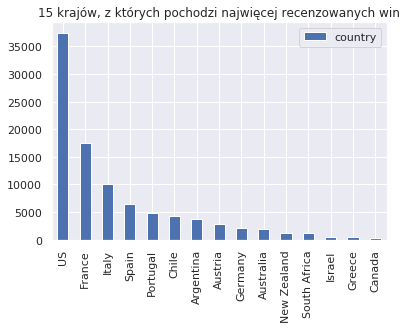

In [8]:
print(f"Recenzowane wina pochodzą z {df['country'].nunique()} krajów ")

top_15_countries = df['country'].value_counts().to_frame()[0:15]
top_15_countries.plot.bar(y='country', title='15 krajów, z których pochodzi najwięcej recenzowanych win')
plt.show()

Najwięcej recenzowanych win pochodzi z USA. Niemal równie dużo pochodzi z krajów Europy.

### Kraje

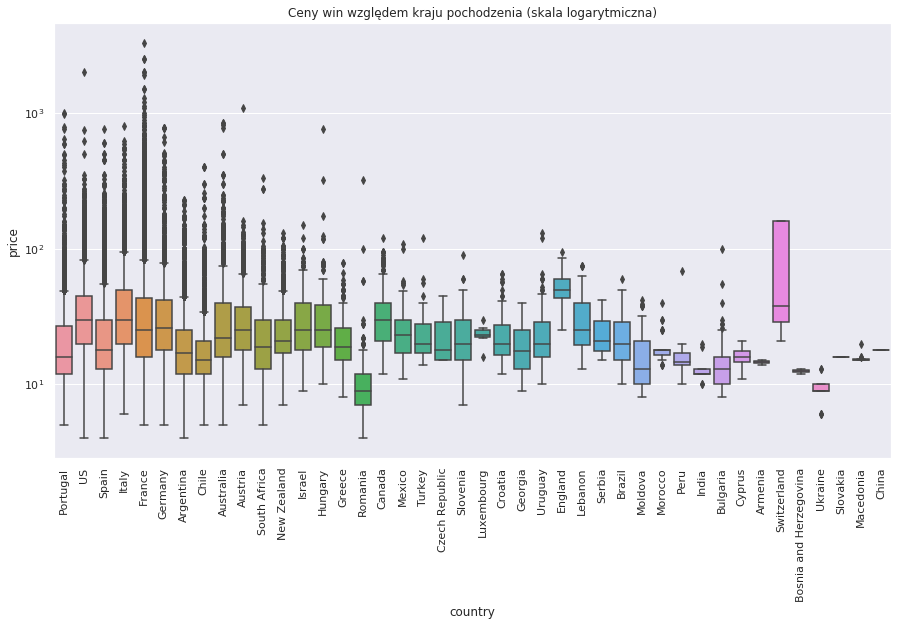

In [9]:
plt.figure(figsize=(15,8))
sns.boxplot(x = df['country'], y = df['price'])
plt.yscale("log")
plt.title('Ceny win względem kraju pochodzenia (skala logarytmiczna)')
plt.xticks(rotation=90)
plt.show()

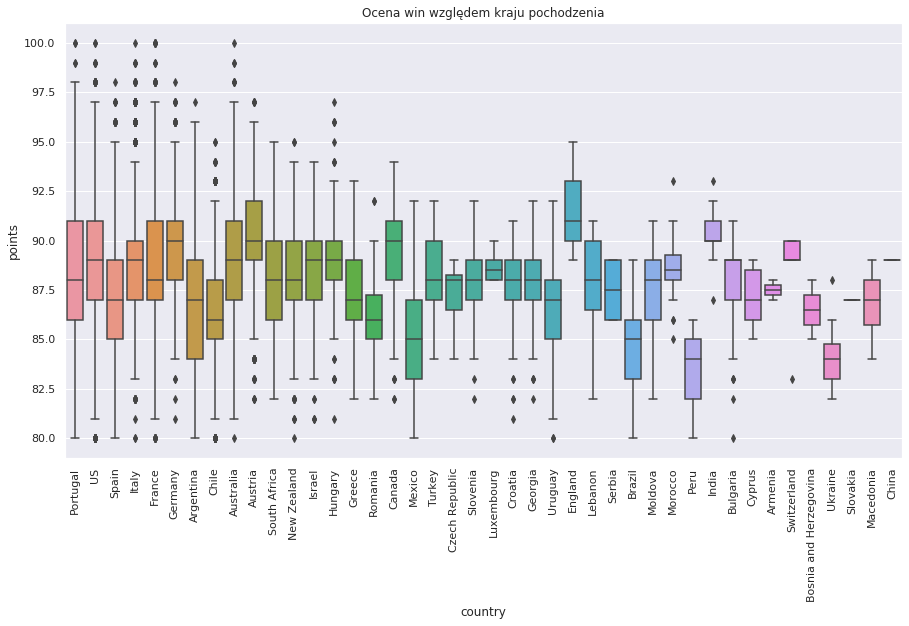

In [10]:
plt.figure(figsize=(15,8))
sns.boxplot(x = df['country'], y = df['points'])
plt.title('Ocena win względem kraju pochodzenia')
plt.xticks(rotation=90)
plt.show()

Szwajcaria i Anglia mają najdroższe wina. Anglia ma również najlepsze wina w naszym zestawieniu. Jednak liczebność tych win jest za mała, żeby można było wyciągnąć wnioski.

In [11]:
df_repr = df['country'].value_counts()/df.shape[0]
df_valid_countries = df[df['country'].isin(df_repr[df_repr > 0.001].index)]
print(f"Analizujemy wina z {df_valid_countries['country'].nunique()} krajów")

Analizujemy wina z 19 krajów


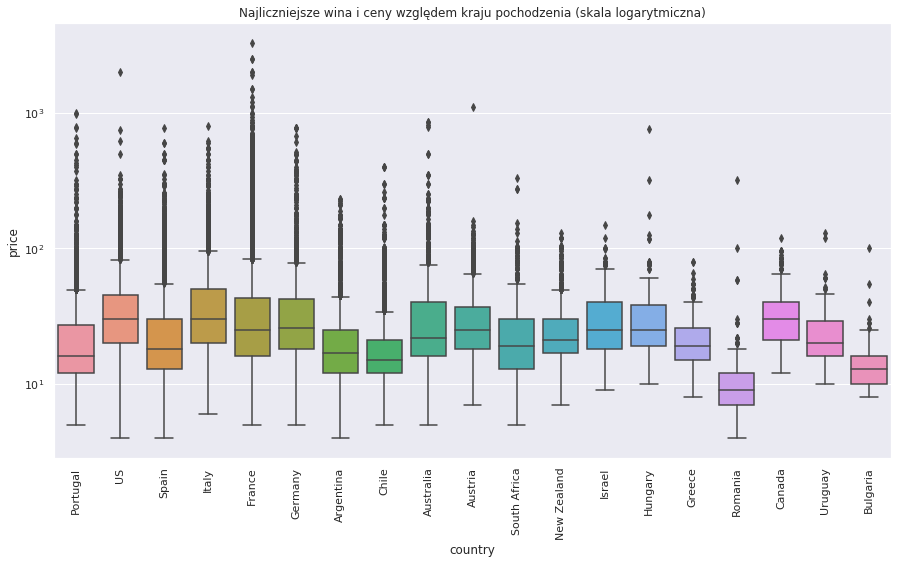

In [12]:
plt.figure(figsize=(15,8))
sns.boxplot(x = df_valid_countries['country'], 
            y = df_valid_countries['price'])
plt.yscale("log")
plt.title('Najliczniejsze wina i ceny względem kraju pochodzenia (skala logarytmiczna)')
plt.xticks(rotation=90)
plt.show()

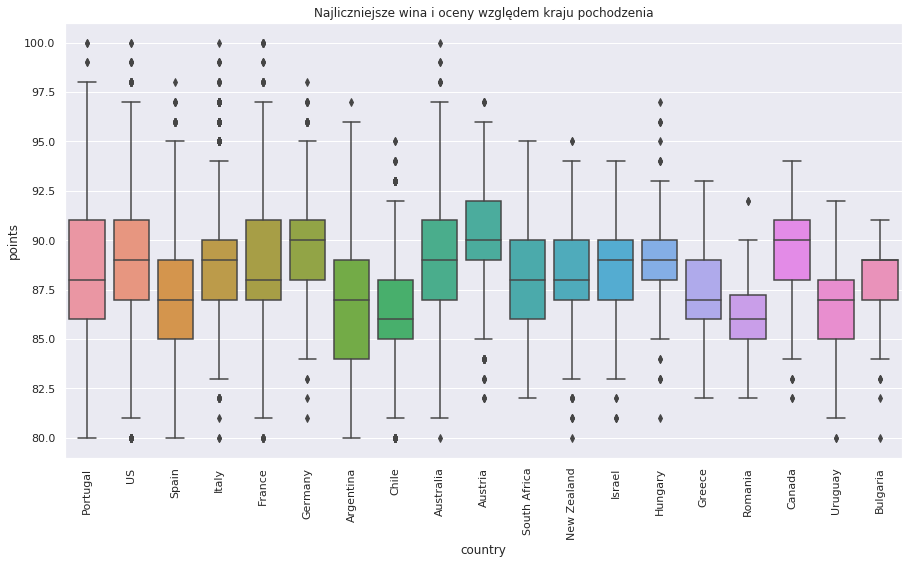

In [13]:
plt.figure(figsize=(15,8))
sns.boxplot(x = df_valid_countries['country'], 
            y = df_valid_countries['points'])
plt.title('Najliczniejsze wina i oceny względem kraju pochodzenia')
plt.xticks(rotation=90)
plt.show()

Lepiej od pozostałych wypadają wina z Kanady i Austrii, ale z najwyższej półki pochodzą z Portugalii, Australii, Francji i Stanów Zjednoczonych.

### Regiony

Recenzowane wina pochodzą z 417 regionów


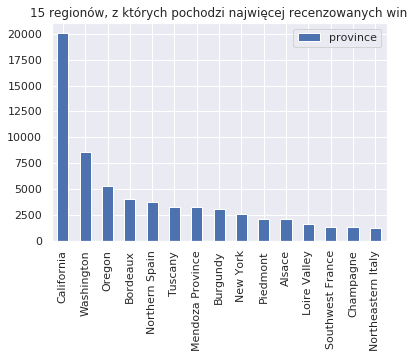

In [14]:
print(f"Recenzowane wina pochodzą z {df['province'].nunique()} regionów")
top_15_provinces = df['province'].value_counts().to_frame()[0:15]
top_15_provinces.plot.bar(y='province', title='15 regionów, z których pochodzi najwięcej recenzowanych win')
plt.show()

In [15]:
df_prov_repr = df['province'].value_counts()/df.shape[0]
df_valid_provinces = df[df['province'].isin(df_prov_repr[df_prov_repr > 0.001].index)]
print(f"Analizujemy wina z {df_valid_provinces['province'].nunique()} regionów")

Analizujemy wina z 80 regionów


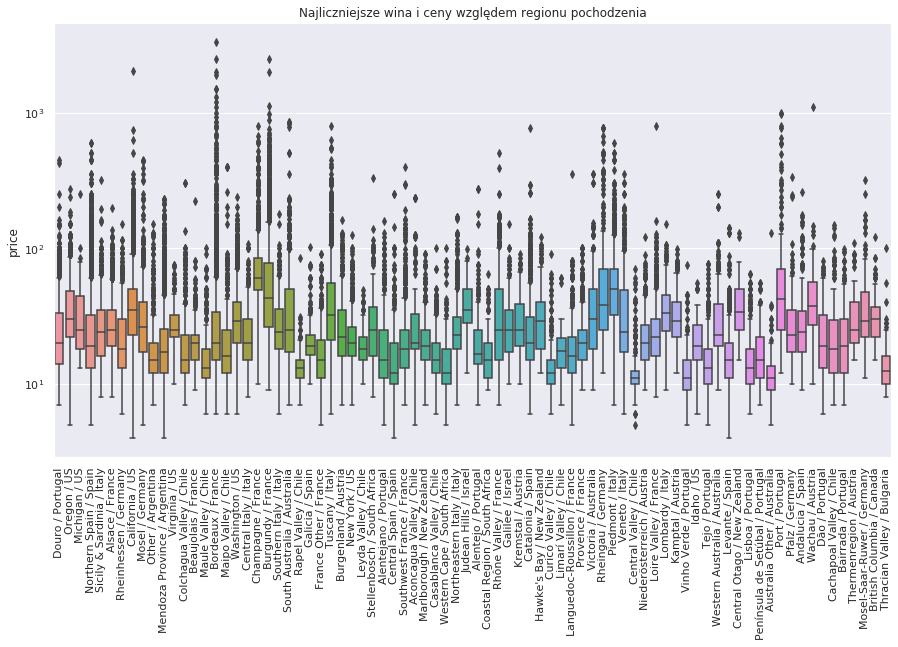

In [16]:
plt.figure(figsize=(15,8))
sns.boxplot(x = df_valid_provinces[['province', 'country']].apply(lambda x: ' / '.join(x), axis=1), 
            y = df_valid_provinces['price'])
plt.title('Najliczniejsze wina i ceny względem regionu pochodzenia')
plt.yscale("log")
plt.xticks(rotation=90)
plt.show()

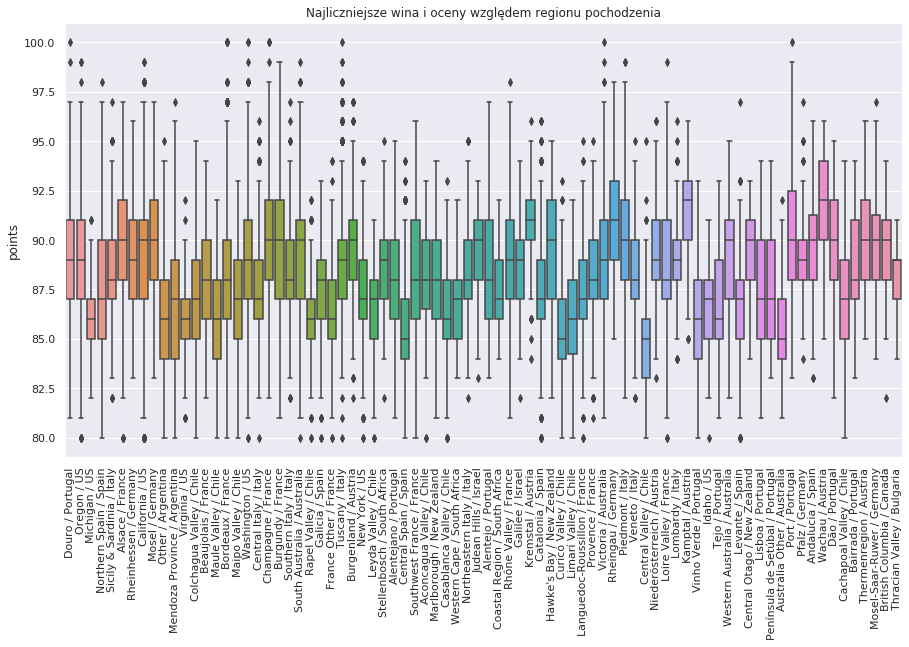

In [17]:
plt.figure(figsize=(15,8))
sns.boxplot(x = df_valid_provinces[['province', 'country']].apply(lambda x: ' / '.join(x), axis=1), 
            y = df_valid_provinces['points'])
plt.title('Najliczniejsze wina i oceny względem regionu pochodzenia')
plt.xticks(rotation=90)
plt.show()

Na powyższym wykresie znów widać, że wina z Austrii wypadają bardzo dobrze (Kamptal i Wachau). Jeśli poszukujemy najlepszych win warto rozpocząć poszukiwania od pochodzących z Porto (Portugalia) i Burgundia (Francja).

### Cena

In [18]:
def show_outliers(dataframe, column):
    cut = dataframe[column].std() * 3

    lower, upper = dataframe[column].mean() - cut, dataframe[column].mean() + cut

    lower_outliers = df[dataframe[column] < lower][column]
    upper_outliers = df[dataframe[column] > upper][column]

    print(f"Najmniejsza górna wartość odstająca: {upper_outliers.min()}")
    print(f"Liczba dolnych wartości odstających: {upper_outliers.count()} "
          f"({(upper_outliers.count()/dataframe[column].count()*100).item():.2f}%)")
    print(f"Największa dolna wartość odstająca: {lower_outliers.max()}")
    print(f"Liczba górnych wartości odstających: {lower_outliers.count()} "
          f"({(lower_outliers.count()/dataframe[column].count()*100).item():.2f}%)")

In [19]:
show_outliers(df, 'price')

Najmniejsza górna wartość odstająca: 165.0
Liczba dolnych wartości odstających: 909 (0.94%)
Największa dolna wartość odstająca: nan
Liczba górnych wartości odstających: 0 (0.00%)


In [20]:
df_variety_repr = df['variety'].value_counts()/df.shape[0]
df_valid_varieties = df[df['variety'].isin(df_variety_repr[df_variety_repr > 0.01].index)]
print(f"Analizujemy wina {df_valid_varieties['variety'].nunique()} gatunków")

Analizujemy wina 24 gatunków


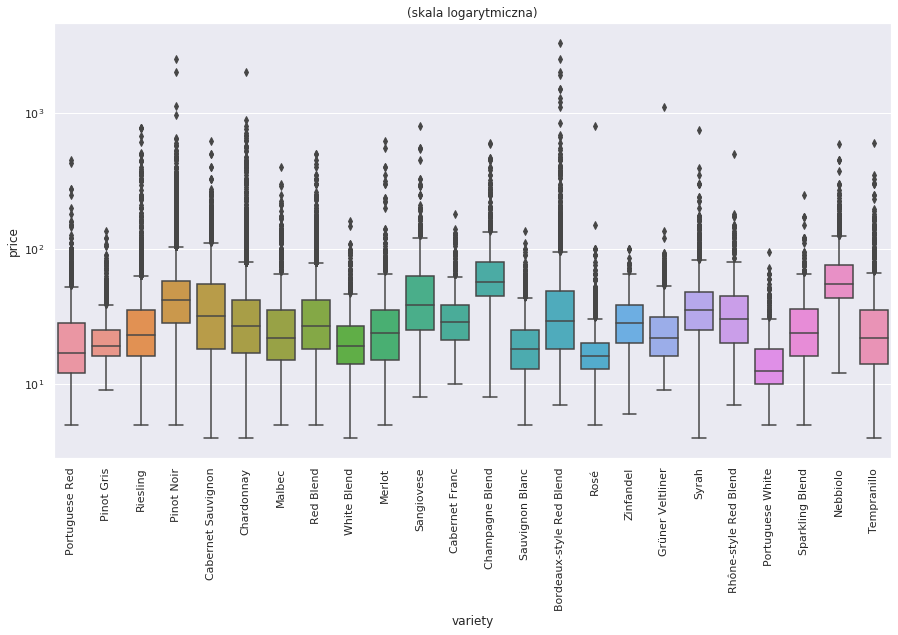

In [21]:
plt.figure(figsize=(15,8))
sns.boxplot(x = df_valid_varieties['variety'], 
            y = df_valid_varieties['price'])
plt.yscale("log")
plt.title('(skala logarytmiczna)')
plt.xticks(rotation=90)
plt.show()

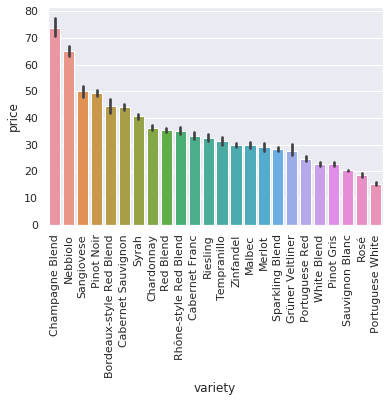

In [22]:
varieties_means = df_valid_varieties.groupby('variety')['price'].mean()
varieties_means.sort_values(ascending=False, inplace=True)

sns.barplot(x='variety',y='price', data=df_valid_varieties, order=varieties_means.index)
plt.xticks(rotation = 90)
plt.show()

Za Chapagne Blend i Nebbiolo przyjdzie Nam najwięcej zapłacić.

### Punkty

In [23]:
show_outliers(df, 'points')

Najmniejsza górna wartość odstająca: 98
Liczba dolnych wartości odstających: 83 (0.09%)
Największa dolna wartość odstająca: nan
Liczba górnych wartości odstających: 0 (0.00%)


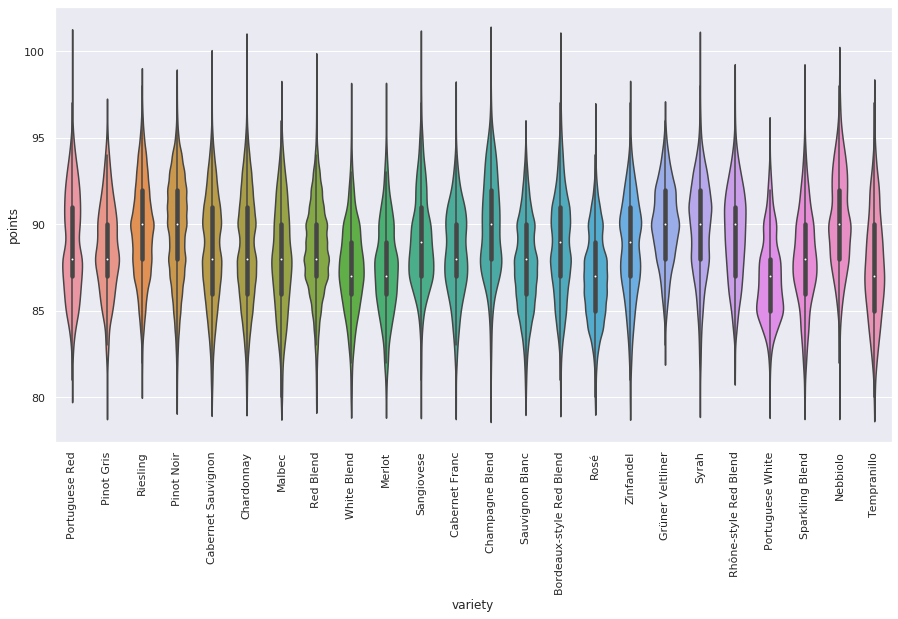

In [24]:
plt.figure(figsize=(15,8))
sns.violinplot(x='variety',y='points',data=df_valid_varieties)
plt.xticks(rotation=90)
plt.show()

### Stosunek cena do jakość

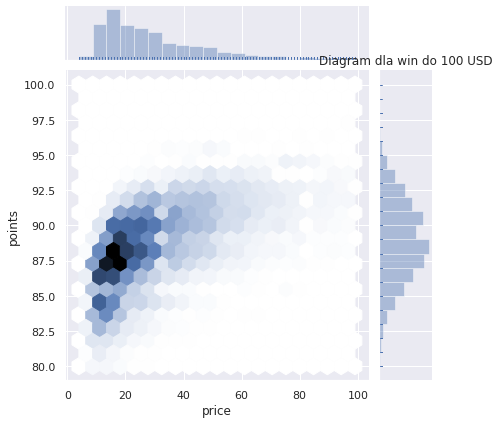

In [25]:
sns.jointplot(x='price', y='points', data=df[df['price'] < 100], kind='hex', 
               marginal_kws=dict(bins=20, rug=True), gridsize=20)
plt.title('Diagram dla win do 100 USD')
plt.show()

Wino ze średniej półki to przeważnie koszt 15-30 USD.

In [26]:
q1 = df.price.quantile(.25)
q2 = df.price.quantile(.5)
q3 = df.price.quantile(.75)

df_price_q1 = df[df.price < q1].reset_index(drop=True)
df_price_q1 = df_price_q1.dropna().reset_index(drop=True)

df_price_q2 = df[(df.price < q2) & (df.price >= q1)].reset_index(drop=True)
df_price_q2 = df_price_q2.dropna().reset_index(drop=True)

df_price_q3 = df[(df.price < q3) & (df.price >= q2)].reset_index(drop=True)
df_price_q3 = df_price_q3.dropna().reset_index(drop=True)

df_price_q4 = df[df.price >= q3].reset_index(drop=True)
df_price_q4 = df_price_q4.dropna().reset_index(drop=True)

print(f"Cena od {df_price_q1['price'].min()} do {q1} USD średnia liczba punktów: {df_price_q1['points'].mean():.2f}")
print(f"Cena od {q1} do {q2} USD średnia liczba punktów: {df_price_q2['points'].mean():.2f}")
print(f"Cena od {q2} do {q3} USD średnia liczba punktów: {df_price_q3['points'].mean():.2f}")
print(f"Cena od {q3} do {df_price_q4['price'].max()} USD średnia liczba punktów: {df_price_q4['points'].mean():.2f}")
print(f"Średnia dla całego zbioru {df['points'].mean():.2f}")

Cena od 4.0 do 17.0 USD średnia liczba punktów: 86.22
Cena od 17.0 do 25.0 USD średnia liczba punktów: 87.87
Cena od 25.0 do 40.0 USD średnia liczba punktów: 89.01
Cena od 40.0 do 3300.0 USD średnia liczba punktów: 90.88
Średnia dla całego zbioru 88.59


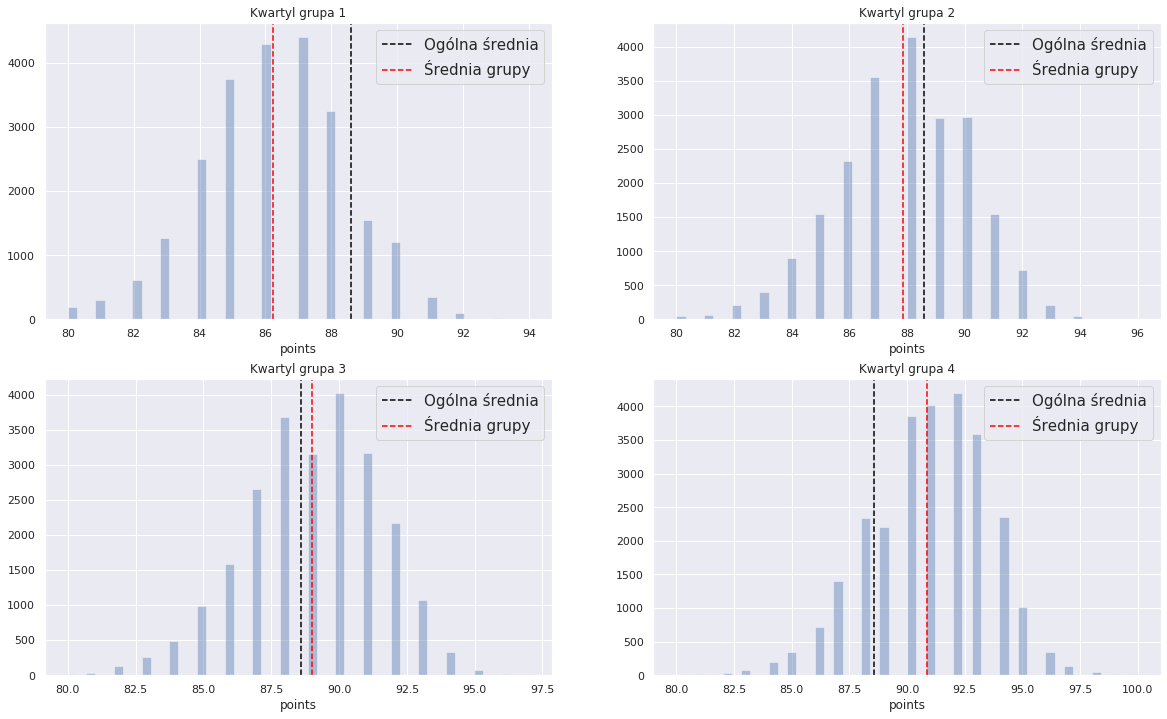

In [27]:
plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)

plt.title('Kwartyl grupa 1')
sns.distplot( df_price_q1['points'], kde=False)
plt.axvline(np.mean(df['points']), 0, 1, linestyle='--', color='black', label='Ogólna średnia')
plt.axvline(np.mean(df_price_q1['points']), 0, 1, linestyle='--', color='red', label='Średnia grupy')
plt.legend(fontsize=15)

plt.subplot(2, 2, 2)
plt.title('Kwartyl grupa 2')
sns.distplot( df_price_q2['points'], kde=False)
plt.axvline(np.mean(df['points']), 0, 1, linestyle='--', color='black', label='Ogólna średnia')
plt.axvline(np.mean(df_price_q2['points']), 0, 1, linestyle='--', color='red', label='Średnia grupy')
plt.legend(fontsize=15)

plt.subplot(2, 2, 3)
plt.title('Kwartyl grupa 3')
sns.distplot( df_price_q3['points'], kde=False)
plt.axvline(np.mean(df['points']), 0, 1, linestyle='--', color='black', label='Ogólna średnia')
plt.axvline(np.mean(df_price_q3['points']), 0, 1, linestyle='--', color='red', label='Średnia grupy')
plt.legend(fontsize=15)

plt.subplot(2, 2, 4)
plt.title('Kwartyl grupa 4')
sns.distplot( df_price_q4['points'], kde=False)
plt.axvline(np.mean(df['points']), 0, 1, linestyle='--', color='black', label='Ogólna średnia')
plt.axvline(np.mean(df_price_q4['points']), 0, 1, linestyle='--', color='red', label='Średnia grupy')
plt.legend(fontsize=15)

plt.show()

W każdej z kolejnych grup cenowych podnosi się średnia liczba przyznanych punktów, a rozkład przechodzi z asymetrii lewostronnej w grupie najtańszych do prawostronnej w najdroższych.

In [28]:
corr_pearson = df[['points']].corrwith(df['price'], method='pearson')[0]
print(f'Współczynnik korelacji Pearsona pomiędzy points a price: {corr_pearson:.4f}')
corr_kendall = df[['points']].corrwith(df['price'], method='kendall')[0]
print(f'Współczynnik korelacji Kendalla pomiędzy points a price: {corr_kendall:.4f}')
corr_spearman = df[['points']].corrwith(df['price'], method='spearman')[0]
print(f'Współczynnik korelacji Spearmana pomiędzy points a price: {corr_spearman:.4f}')
corr_pearson = df[['points']].corrwith(df['log_price'], method='pearson')[0]
print(f'Współczynnik korelacji Pearsona pomiędzy points a log_price: {corr_pearson:.4f}')

Współczynnik korelacji Pearsona pomiędzy points a price: 0.4040
Współczynnik korelacji Kendalla pomiędzy points a price: 0.4672
Współczynnik korelacji Spearmana pomiędzy points a price: 0.6208
Współczynnik korelacji Pearsona pomiędzy points a log_price: 0.6223


Współczynniki korelacji Spearmana wskazuje, że mamy silną tendecję wzrostu ceny wraz ze wzrostem liczby przyznanej punktów, ale współczynnik korelacji Pearsona wskazuje słabą korelację liniową.

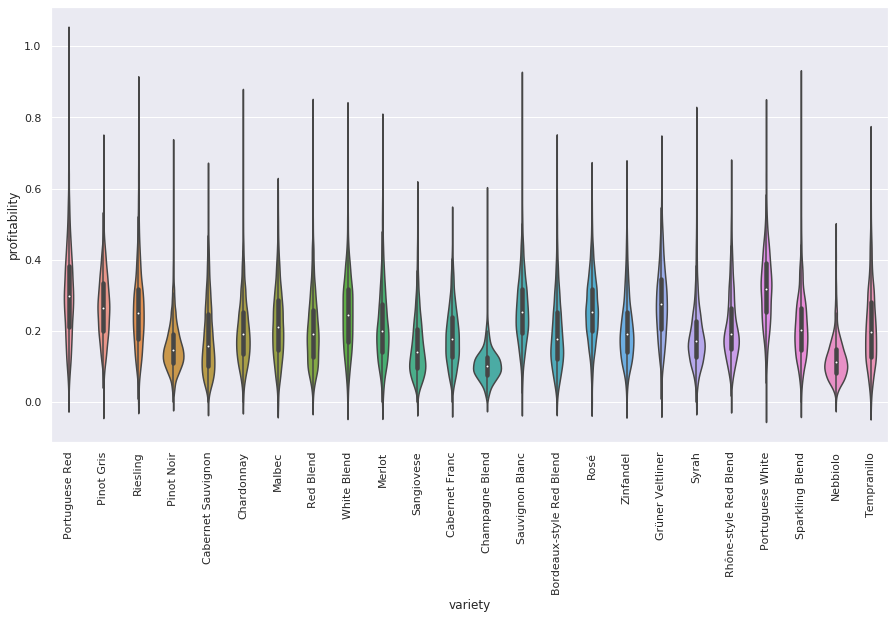

In [29]:
top_varieties_w_prof = df_valid_varieties.copy()
top_varieties_w_prof['profitability'] = (df_valid_varieties['points']-80)/df_valid_varieties['price']
top_varieties_w_prof['profitability'] = top_varieties_w_prof['profitability']\
                        /(top_varieties_w_prof['profitability'].max())

plt.figure(figsize=(15,8))
sns.violinplot(x='variety',y='profitability',data=top_varieties_w_prof)
plt.xticks(rotation=90)
plt.show()

In [30]:
corr_pearson_matrix = df_valid_varieties[['points', 'price', 'variety']].groupby(['variety']).corr()
v = corr_pearson_matrix[np.in1d(corr_pearson_matrix.index.get_level_values(1), ['price'])]
v = v.droplevel(1).drop(columns=['price'])
v.rename(columns={'points':'coef0'}, inplace=True)
v.sort_values(by='coef0', ascending=False)

,coef0
variety,
Portuguese White,0.619961
Portuguese Red,0.586486
Sauvignon Blanc,0.574788
Pinot Gris,0.563752
Cabernet Sauvignon,0.551462
Sparkling Blend,0.549976
Tempranillo,0.531784
Rhône-style Red Blend,0.530264
Malbec,0.528304


Jeśli chcemy spróbować dobrego Portuguese White, Portuguese Red	lub Sauvignon Blanc	warto dopłacić. W przypadku, gdy zdecydujemy się zaoszczędzić na Bordeaux-style Red Blend, Grüner Veltliner i Rosé możemy wcale tego nie odczuć.

### Wątpliwości co do wniosków

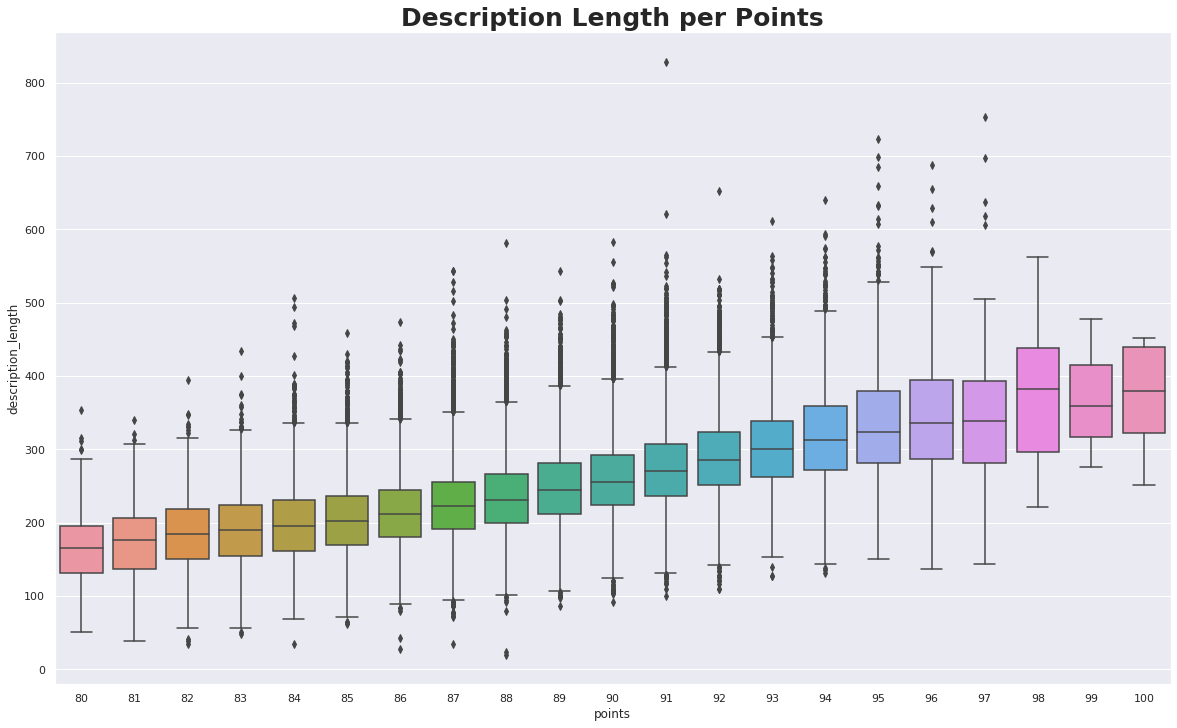

In [31]:
fig, ax = plt.subplots(figsize=(20,12))
sns.boxplot(x='points', y='description_length', data=df)
ax.set_title('Description Length per Points', fontweight="bold", size=25)
plt.show()

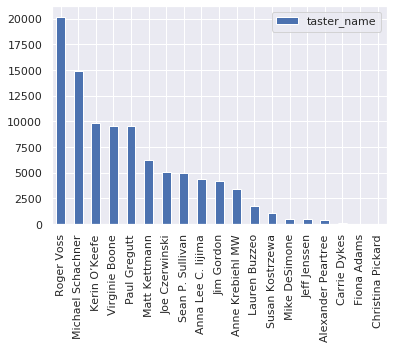

In [32]:
top_15_tasters = df['taster_name'].value_counts().to_frame()
top_15_tasters.plot.bar(y='taster_name', title='')
plt.show()

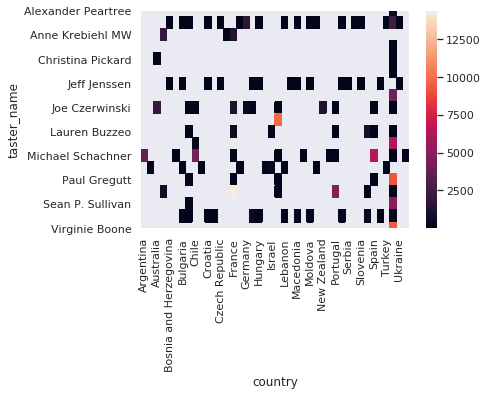

In [33]:
reviews = df.groupby(['country', 'taster_name']).size().reset_index(name='counts')
reviews = reviews.pivot('taster_name', 'country', 'counts')
sns.heatmap(reviews)
plt.show()

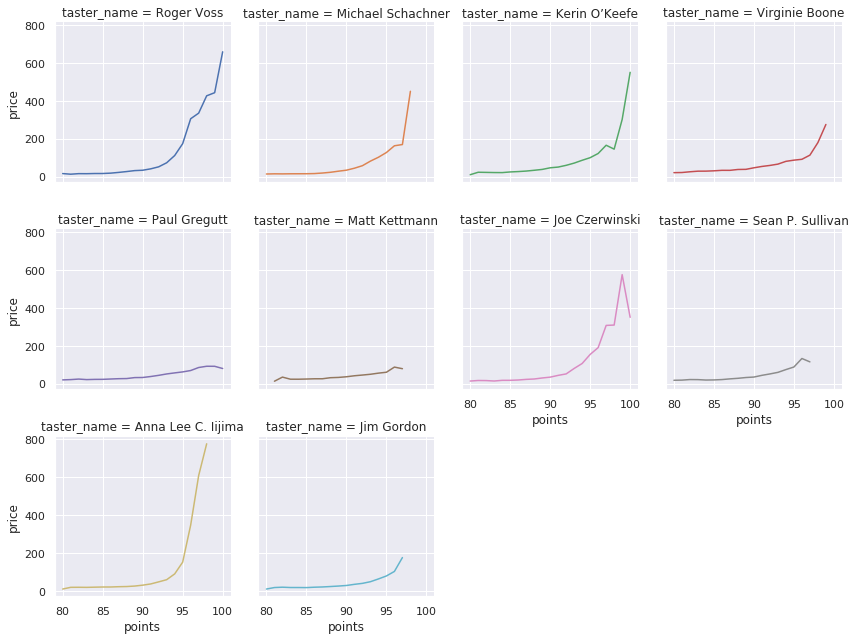

In [34]:
df_top_tasters = df[df['taster_name'].isin(df['taster_name'].value_counts().head(10).index)]
df_taster_points = df_top_tasters.groupby(['taster_name', 'points'])['price'].mean().reset_index()

index = []
for name in df['taster_name'].value_counts().head(10).index:
    bool_table = df_taster_points['taster_name'] == name
    index += list(bool_table[bool_table].index)
    
df_taster_points = df_taster_points.reindex(index)
grid = sns.FacetGrid(df_taster_points, 
                     col="taster_name", hue="taster_name", 
                     col_wrap=4, height=3)
grid.map(plt.plot, "points", "price")
plt.show()

Jak widać, każdy recenzent ma inny styl oceniania win.

Nie bez znaczenia jest efekt psychologiczny ceny. Jeśli rencenzent zna cenę wina przed jego ocenieniem może mieć to wpływ na przyznaną liczbę punktów. 10 najczęściej oceniających ma różne tendencje wzrostu cen. Powyżej widać, że recenzenci zazwyczaj ograniczają się do kilku krajów.

### Podsumowanie

In [35]:
df[df['points']==100]

,country,points,price,province,taster_name,variety,winery,description,description_length,log_price
345,Australia,100,350.0,Victoria,Joe Czerwinski,Muscat,Chambers Rosewood Vineyards,This wine contains some material over 100 year...,397,5.857933
36528,France,100,259.0,Champagne,Roger Voss,Champagne Blend,Krug,This is a fabulous wine from the greatest Cham...,392,5.556828
42197,Portugal,100,450.0,Douro,Roger Voss,Portuguese Red,Casa Ferreirinha,This is the latest release of what has long be...,449,6.109248
45781,Italy,100,550.0,Tuscany,Kerin O’Keefe,Sangiovese,Biondi Santi,"This gorgeous, fragrant wine opens with classi...",434,6.309918
58352,France,100,150.0,Bordeaux,Roger Voss,Bordeaux-style Red Blend,Château Léoville Barton,"This is a magnificently solid wine, initially ...",341,5.010635
89728,France,100,250.0,Champagne,Roger Voss,Champagne Blend,Louis Roederer,This latest incarnation of the famous brand is...,452,5.521461
89729,France,100,617.0,Champagne,Roger Voss,Chardonnay,Salon,This new release from a great vintage for Char...,333,6.424869
111753,France,100,1500.0,Bordeaux,Roger Voss,Bordeaux-style Red Blend,Château Lafite Rothschild,"Almost black in color, this stunning wine is g...",252,7.313220
111755,France,100,1500.0,Bordeaux,Roger Voss,Bordeaux-style Red Blend,Château Cheval Blanc,This is the finest Cheval Blanc for many years...,368,7.313220
111756,France,100,359.0,Bordeaux,Roger Voss,Bordeaux-style Red Blend,Château Léoville Las Cases,"A hugely powerful wine, full of dark, brooding...",319,5.883322


Dwukrotnie ideałem wina została wskazana Syrah z Walla Walla Valley w USA, stanie Waszyngton o wartości 80 USD - tak uważa Paul Gregutt, u którego najlepiej punktowane wina nie są wyłącznie bardzo drogie co wynika z wykresu powyżej. 

W analizie tego zbioru podjąłem próbę ustalenia który czynnik na największe znaczenie, ale nie udało mi się zrobić predykcji oceny na podstawie gatunku, kraju, regionu, producenta czy recenzenta. Jednak cena zawsze miała duże znaczenie na co wskazuje współczynnik Pearsona. Warto zaznaczyć, że ceny mają rozkład wykładniczy, zatem nałożenie logarytmu na ceny powoduje, że mamy dość dużą korelację z ceną. Wskazuje to jednoznacznie, że za najlepsze wino przyjdzie Nam zapłacić znacznie więcej niż za przeciętne. Ponadto można mieć pewne wątpliwości co do stronniczości recenzentów, ale uzasadniona jest bardziej szczegółowa recenzja dobrego wina, jak i wyższa jego cena, ze względu na koszt powstania butelki dobrego trunku. Istotnym jest też to, że ceny dóbr luksusowych zwykle charakteryzuje taki rozkład. Istotność producenta, gatunku, pochodzenia jest tak niewielka, że nie powinniśmy się nią kierować przy wyborze.

Ciekawym jest fakt, że regiony, które mają wyrobioną markę oferują zarówno wina niskiej jak i wysokiej jakości (np. Bordeaux), a regiony Austrii urzymują przeciętny poziom. W pierwszym przypadku wniosek jest oczywisty, że przy wyborze wina, zwłaszcza na półce w markecie (możliwe, że takie w naszej analizie pojawiły się w drodze wyjątku) nie powinniśmy się kierować wyłącznie regionem. W drugim przypadku możliwe jest, że niektóre wina są słabiej reprezentowane.

### Predykcja gatunku z wykorzystaniem analizy tekstu

Spróbujmy nauczyć model, który będzie przewidywał gatunek wina na podstawie kolumn *description* i *price*.

In [36]:
df = df_valid_varieties[['country', 'points', 'price', 'variety', 'description']]
df = df_valid_varieties.drop_duplicates('description')

Usuwamy powtarzające się recenzje, uzupełniamy brakujące ceny średnią i wyrzucamy tam gdzie brakuje wartości w kraju

In [37]:
stopword_list = stopwords.words('english')
rt = RegexpTokenizer(r'\w+')
ps = PorterStemmer()

for i in range(1, df.tail(1).index[0] + 1):
    try:
        description_words = rt.tokenize(df['description'][i])
        description_lower = [w.lower() for w in description_words]        
        description_nonstop = [word for word in description_lower 
                               if not word in stopword_list]
        description_stemmed = [ps.stem(word) for word in description_nonstop]
        df['description'][i] = ' '.join(description_stemmed)
    except:
        pass

/home/marrowne/.conda/envs/ml19/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/marrowne/.conda/envs/ml19/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Przygotowujemy kolumnę *description* do analizy na tekście. 

In [38]:
df

,country,points,price,province,taster_name,variety,winery,description,description_length,log_price
1,Portugal,87,15.0,Douro,Roger Voss,Portuguese Red,Quinta dos Avidagos,ripe fruiti wine smooth still structur firm ta...,227,2.708050
2,US,87,14.0,Oregon,Paul Gregutt,Pinot Gris,Rainstorm,tart snappi flavor lime flesh rind domin green...,186,2.639057
3,US,87,13.0,Michigan,Alexander Peartree,Riesling,St. Julian,pineappl rind lemon pith orang blossom start a...,199,2.564949
4,US,87,65.0,Oregon,Paul Gregutt,Pinot Noir,Sweet Cheeks,much like regular bottl 2012 come across rathe...,249,4.174387
9,France,87,27.0,Alsace,Roger Voss,Pinot Gris,Jean-Baptiste Adam,great depth flavor fresh appl pear fruit touch...,160,3.295837
...,...,...,...,...,...,...,...,...,...,...
129963,Israel,90,20.0,Galilee,Mike DeSimone,Cabernet Sauvignon,Dalton,bouquet black cherri tart cranberri clove open...,345,2.995732
129965,France,90,28.0,Alsace,Roger Voss,Pinot Gris,Domaine Rieflé-Landmann,rich beauti dri wine also offer consider fresh...,211,3.332205
129966,Germany,90,28.0,Mosel,Anna Lee C. Iijima,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),note honeysuckl cantaloup sweeten delici feath...,227,3.332205
129967,US,90,75.0,Oregon,Paul Gregutt,Pinot Noir,Citation,citat given much decad bottl age prior releas ...,233,4.317488


Chcemy pominąć nazwę gatunku jeśli pojawi się w opisie.

In [39]:
output = set()
for x in df.variety:
    for y in x.lower().split():
        output.add(y)
varieties_list = sorted(output)

stop = set(stopwords.words('english'))
stop.update(varieties_list)

In [40]:
X = df[['description', 'price']]
y = df['variety'].factorize()[0]

Z wcześniej przeprowadzonej analizy wynika, że ceny są charakterystyczne dla gatunku wina. Warto je wykorzystać przy predykcji.

In [41]:
kfold = StratifiedKFold(n_splits=5, random_state=42)
cntVect = CountVectorizer(stop_words = stop)

X_cnt = cntVect.fit_transform(X['description'].to_numpy())
price = X['price'].to_numpy()[:,None]
X_cnt_price = hstack((X_cnt, price))

param_grid = {'estimator__C': np.logspace(-3,2,6)}

log_reg_clf = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=500))

grid_lr = GridSearchCV(log_reg_clf, param_grid, cv=kfold, return_train_score=True)
grid_lr.fit(X_cnt_price, y)

best_params_idx = grid_lr.cv_results_['params'].index(grid_lr.best_params_)
best_accuracy = grid_lr.cv_results_['mean_test_score'][best_params_idx]
best_std = grid_lr.cv_results_['std_test_score'][best_params_idx]
print(f'Accuracy - mean:{best_accuracy*100:.2f}% std:{best_std*100:.2f}% @ params:{grid_lr.best_params_}')

/home/marrowne/.conda/envs/ml19/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bordeaux', 'rhône', 'style'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Accuracy - mean:62.79% std:0.56% @ params:{'estimator__C': 1.0}


### Random Forest

In [42]:
valid_varieties = df_valid_varieties[['country', 'description', 'points', 'price', 'variety']].copy()
valid_varieties['variety_id'] = valid_varieties['variety'].factorize()[0]

In [43]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        encoding='UTF-8', ngram_range=(1, 2), 
                        stop_words='english') 

X = tfidf.fit_transform(valid_varieties.description)
y = valid_varieties['variety_id']

In [44]:
kfold = StratifiedKFold(n_splits=5, random_state=42)

param_grid = {'n_estimators': [10, 100, 500]}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=kfold, return_train_score=True)
grid_rf.fit(X, y.to_numpy())

best_params_idx = grid_rf.cv_results_['params'].index(grid_rf.best_params_)
best_accuracy = grid_rf.cv_results_['mean_test_score'][best_params_idx]
best_std = grid_rf.cv_results_['std_test_score'][best_params_idx]
print(f'Accuracy - mean:{best_accuracy*100:.2f}% std:{best_std*100:.2f}% @ params:{grid_rf.best_params_}')

Accuracy - mean:66.52% std:0.36% @ params:{'n_estimators': 500}


### SVM

In [45]:
kfold = StratifiedKFold(n_splits=5, random_state=42)

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid_svm = GridSearchCV(LinearSVC(), param_grid, cv=kfold, return_train_score=True)
grid_svm.fit(X, y.to_numpy())

best_params_idx = grid_svm.cv_results_['params'].index(grid_svm.best_params_)
best_accuracy = grid_svm.cv_results_['mean_test_score'][best_params_idx]
best_std = grid_svm.cv_results_['std_test_score'][best_params_idx]
print(f'Accuracy - mean:{best_accuracy*100:.2f}% std:{best_std*100:.2f}% @ params:{grid_svm.best_params_}')

/home/marrowne/.conda/envs/ml19/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy - mean:73.00% std:0.41% @ params:{'C': 1}


Wszystkie modele okazały się być stabilne, ale jak widać najlepiej radzi sobie liniowy SVM. Jako dalsze usprawnienie można wymienić SVM z wielomianem stopnia 2. (stopień 3. prawdopodobnie raczej nie będzie potrzebny), konwolucyjną sieć neuronową oraz ...